# Data Analysis in R

In [133]:
model_count

[1] 3

In [127]:
# Imports
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))

# Load data
frData <- read.csv('../Data/CRat_prepped.csv', stringsAsFactors = FALSE)
frModStats <- read.csv('../Data/ModelStats.csv', stringsAsFactors = FALSE)

# Extract model information
model_count <- (length(frModStats)-6)/2 # assumes only other cols besides ID are aic/bic/rsqd vals and 5 coefficients (holl2 and 3)
model_names <- substr(names(frModStats[2:(1+model_count)]), 1, nchar(names(frModStats[2:(1+model_count)]))-4) #Assumes full model names precede the last 3 chars of header

# Function for comparing model fits for each ID by both AIC and BIC.
compareModels <- function(row){
  id <- as.character(row[1])
  # Works for comparisons for any number of models
  #model_count <- (length(row)-6)/2 # assumes only other cols besides ID are aic/bic vals
  AICs <- sort(row[2:(1+model_count)])
  BICs <- sort(row[(2+model_count):(1+2*model_count)]) # or just until length(row) if no other cols are added
  
  # Extract model names (assumes the only charcters following the model names are 
  # 'AIC' or 'BIC' - as such only clips last 3)
  mod_names <- substr(names(AICs), 1, nchar(names(AICs))-4)
  
  ##################### Find best fit ###########################
  # Initialise best fit charcter vectors (can't preallocate as final length unknown)
  best_fits_aic <- c(AICs[1])
  best_fits_bic <- c(BICs[1])
  
  add_aic <- TRUE
  add_bic <- TRUE
  
  for (i in 2:model_count){
    # Calculate diffs
    deltaAIC <- abs(AICs[i] - AICs[i-1])
    deltaBIC <- abs(BICs[i] - BICs[i-1])
    
    ## Check best according to AIC ##
    while (add_aic){
      if (deltaAIC <= 2){
        # If difference with previous AIC is less than or equal to two
        # then diff insignificant; add to list
        best_fits_aic[i] <- AICs[i]
        break
      } else {
        add_aic <- FALSE
      }
    }
    
    ## Check best according to BIC ##
    while (add_bic){
      if (deltaBIC <= 2){
        # If difference with previous BIC is less than or equal to two
        # Add to list
        best_fits_bic[i] <- BICs[i]
        break
      } else {
        add_bic <- FALSE
      }
    }
  }
  
  names(best_fits_aic) <- mod_names[1:length(best_fits_aic)]
  names(best_fits_bic) <- mod_names[1:length(best_fits_bic)]
  
  # Standardise order (as ties don't matter)
  order <- c('Quadratic', 'Cubic', 'HollingII', 'GFR')
  aic <- names(best_fits_aic)[order(match(names(best_fits_aic), order))]
  bic <- names(best_fits_bic)[order(match(names(best_fits_bic), order))]
  
  # Combine into strings
  AICBestFit <- paste(aic, collapse = '/')
  BICBestFit <- paste(bic, collapse = '/')
  
  return(c(id, AICBestFit, BICBestFit))
}

# Merge best fit results to model stats (using apply over ddply for speed, tested with Sys.time())
bestFits <- as.data.frame(t(apply(frModStats, 1, compareModels)))
colnames(bestFits) <- c('ID', 'AICBestFits', 'BICBestFits')
bestFits$ID <- as.integer(bestFits$ID)
statsWithFits <- left_join(frModStats, bestFits, by = "ID")
metadata <- frData[!duplicated(frData[,1]),][,-c(2,3)] # drop rows with duplicate IDs as metadata same for each ID, and delete N_TraitValue and ResDensity
ALLDATA <- right_join(metadata, statsWithFits, by = "ID") # create df of all relevant fields

In [152]:
# Function for plotting definitive best fits as bar chart
plotBestFits <- function(df, aic_col, bic_col, title){
  n <- nrow(df) 
  
  aicBreakdown <- table(df[,aic_col])
  bicBreakdown <- table(df[,bic_col])
  
  # Preallocate dataframe containing no. of datapoints best explained by each model
  fitdata <- data.frame(Model = rep(model_names, times = 2), 
                        Estimator = rep(c('AIC', 'BIC'), each = model_count),
                        Count = rep(NA, times = 2*model_count))
  
  # Load count of how many IDs were definititvely best fit by each model (draws excluded)
  for (i in 1:nrow(fitdata)){
    mod <- fitdata[i,'Model']
    stat <- fitdata[i,'Estimator']
    if (stat == 'AIC'){
      fitdata[i,'Count'] <- ifelse(is.na(aicBreakdown[mod]), 0, aicBreakdown[[mod]])
    } else {
      fitdata[i,'Count'] <- ifelse(is.na(bicBreakdown[mod]), 0, bicBreakdown[[mod]])
    }
  }
  
  # Plot
  ggplot(data = fitdata, aes(x = factor(Model, levels = c('Quadratic', 'Cubic', 'HollingII', 'GFR')), y = Count, fill = Estimator)) + 
    geom_bar(stat="identity", position = 'dodge') +
    ggtitle(title) +
    labs(x = 'Model', y = 'Best fits') + 
    theme_bw() +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(Count, ' (', round((Count/n)*100, 1), '%)', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 2) +
    expand_limits(y = max(fitdata$Count)*1.02) +
    scale_fill_brewer(palette="Paired")
}

In [153]:
# Imports
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))

# Load data
frData <- read.csv('../Data/CRat_prepped.csv', stringsAsFactors = FALSE)
frModStats <- read.csv('../Data/ModelStats.csv', stringsAsFactors = FALSE)

# Extract model information
model_count <- (length(frModStats)-6)/2 # assumes only other cols besides ID are aic/bic/rsqd vals and 5 coefficients (holl2 and 3)
model_names <- substr(names(frModStats[2:(1+model_count)]), 1, nchar(names(frModStats[2:(1+model_count)]))-4) #Assumes full model names precede the last 3 chars of header

# Function for comparing model fits for each ID by both AIC and BIC.
compareModels <- function(row){
  id <- as.character(row[1])
  # Works for comparisons for any number of models
  #model_count <- (length(row)-6)/2 # assumes only other cols besides ID are aic/bic vals
  AICs <- sort(row[2:(1+model_count)])
  BICs <- sort(row[(2+model_count):(1+2*model_count)]) # or just until length(row) if no other cols are added
  
  # Extract model names (assumes the only charcters following the model names are 
  # 'AIC' or 'BIC' - as such only clips last 3)
  mod_names <- substr(names(AICs), 1, nchar(names(AICs))-4)
  
  ##################### Find best fit ###########################
  # Initialise best fit charcter vectors (can't preallocate as final length unknown)
  best_fits_aic <- c(AICs[1])
  best_fits_bic <- c(BICs[1])
  
  add_aic <- TRUE
  add_bic <- TRUE
  
  for (i in 2:model_count){
    # Calculate diffs
    deltaAIC <- abs(AICs[i] - AICs[i-1])
    deltaBIC <- abs(BICs[i] - BICs[i-1])
    
    ## Check best according to AIC ##
    while (add_aic){
      if (deltaAIC <= 2){
        # If difference with previous AIC is less than or equal to two
        # then diff insignificant; add to list
        best_fits_aic[i] <- AICs[i]
        break
      } else {
        add_aic <- FALSE
      }
    }
    
    ## Check best according to BIC ##
    while (add_bic){
      if (deltaBIC <= 2){
        # If difference with previous BIC is less than or equal to two
        # Add to list
        best_fits_bic[i] <- BICs[i]
        break
      } else {
        add_bic <- FALSE
      }
    }
  }
  
  names(best_fits_aic) <- mod_names[1:length(best_fits_aic)]
  names(best_fits_bic) <- mod_names[1:length(best_fits_bic)]
  
  # Standardise order (as order of ties doesn't matter)
  order <- c('Cubic', 'HollingII', 'GFR')
  aic <- names(best_fits_aic)[order(match(names(best_fits_aic), order))]
  bic <- names(best_fits_bic)[order(match(names(best_fits_bic), order))]

  # Combine into strings
  AICBestFit <- paste(aic, collapse = '/')
  BICBestFit <- paste(bic, collapse = '/')
  
  return(c(id, AICBestFit, BICBestFit))
}

# Merge best fit results to model stats (using apply over ddply for speed, tested with Sys.time())
bestFits <- as.data.frame(t(apply(frModStats, 1, compareModels)))

# Rename cols                                       
colnames(bestFits) <- c('ID', 'AICBestFits', 'BICBestFits')                                          
                                          
MechBias <- function(vec){
  bestfits <- strsplit(vec, '/') # Split strngs into vectors
  bestfitsnew <- rep(NA, length(vec)) # preallocate output vector
  for (i in 1:length(bestfits)){
    fits <- bestfits[[i]]
    # Prioratise HollingII over GFR (clip GFR)
    if (all(tail(fits, 2) == c('HollingII', 'GFR'))){   # AIC
      fits <- head(fits, -1) # remove last element
    }
    # Prioratise mechanistic over phenomenological models
    if (all(head(fits, 2) == c('Cubic', 'HollingII')) | all(head(fits, 2) == c('Cubic', 'GFR')) ){ # AIC
      fits <- fits[-1] # remove first element
    }
    # Load into vector
    bestfitsnew[i] <- fits
  }
  return(bestfitsnew)
}

bestFits$AICBestFits_MechBias <- MechBias(bestFits$AICBestFits)
bestFits$BICBestFits_MechBias <- MechBias(bestFits$BICBestFits)

# Reset column type
bestFits$ID <- as.integer(bestFits$ID)

# Join with main dataframe
statsWithFits <- left_join(frModStats, bestFits, by = "ID")
metadata <- frData[!duplicated(frData[,1]),][,-c(2,3)] # drop rows with duplicate IDs as metadata same for each ID, and delete N_TraitValue and ResDensity
ALLDATA <- right_join(metadata, statsWithFits, by = "ID") # create df of all relevant fields

ALLDATA

ID,ResDensityUnit,TraitUnit,ConTaxa,ResTaxa,Habitat,Con_ForagingMovement,Res_ForagingMovement,Cubic_AIC,HollingII_AIC,⋯,GFR_BIC,h_Holl2,a_Holl2,h_GFR,a_GFR,q_GFR,AICBestFits,BICBestFits,AICBestFits_MechBias,BICBestFits_MechBias
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
39835,Individuals per arena,Individual/(Individual*120 mins),Cyclops bicuspidatus Claus 1857,Panagrolaimus spp.,Freshwater,active,active,-104.716731,-125.02311,⋯,-123.34749,2.929404e+01,9.663936e-05,1.006052e-04,1.280864e-04,-0.108760019,HollingII/GFR,HollingII/GFR,HollingII,HollingII
39836,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-197.851427,-225.50751,⋯,-223.53567,1.670312e+02,2.818301e-05,1.607115e+02,3.013700e-05,-0.018841384,HollingII/GFR,HollingII/GFR,HollingII,HollingII
39837,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-174.367043,-201.55354,⋯,-198.99262,1.652989e+02,1.301181e-05,1.114400e+02,1.673661e-05,-0.070704689,HollingII/GFR,HollingII/GFR,HollingII,HollingII
39838,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-205.546383,-233.83627,⋯,-230.94224,1.680778e+02,6.239453e-06,1.739917e+02,6.142309e-06,0.004313723,HollingII/GFR,HollingII,HollingII,HollingII
39839,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-200.139300,-212.86562,⋯,-213.84006,5.753898e+02,5.132006e-06,4.228669e+01,1.511569e-05,-0.289631353,HollingII/GFR,HollingII/GFR,HollingII,HollingII
39840,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-16.753945,-116.55076,⋯,-110.96360,1.281639e+00,5.701892e-01,6.772360e-09,3.209593e-01,-0.559045779,HollingII/GFR,HollingII,HollingII,HollingII
39841,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-38.616104,-151.96439,⋯,-145.61726,9.340270e-01,1.849437e+00,1.020914e+00,2.421256e+00,0.279070670,HollingII/GFR,HollingII,HollingII,HollingII
39842,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-4.169312,-94.44293,⋯,-88.10865,8.998094e-01,1.008196e+00,9.960792e-01,1.125236e+00,0.246967313,HollingII/GFR,HollingII,HollingII,HollingII
39843,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-26.538195,-106.69039,⋯,-101.33954,8.625581e-01,1.794689e+00,9.628883e-01,2.395226e+00,0.288655836,HollingII/GFR,HollingII,HollingII,HollingII


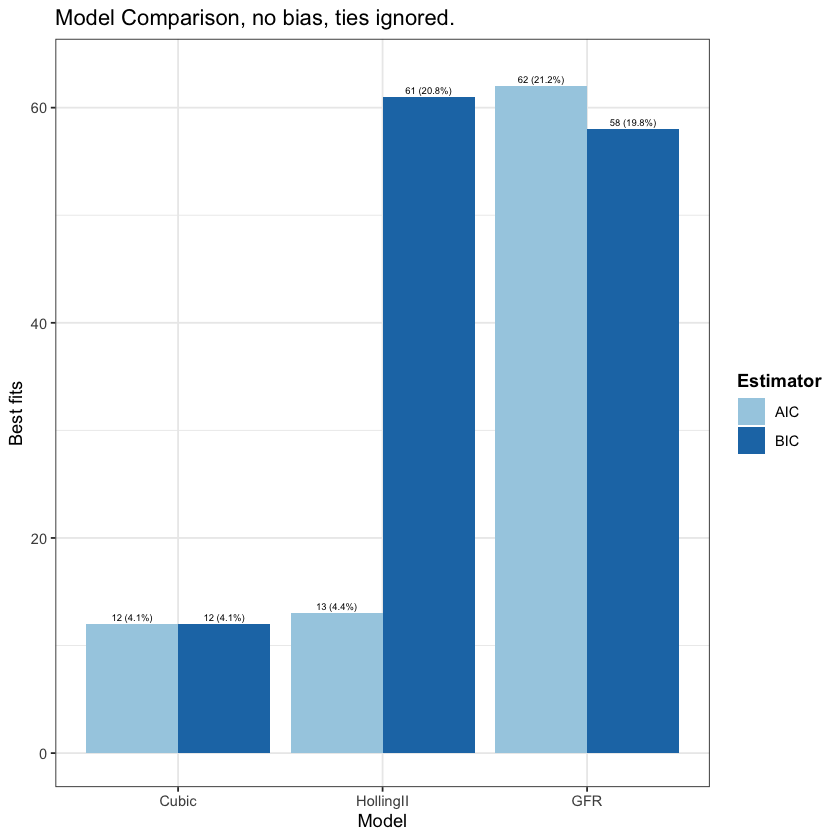

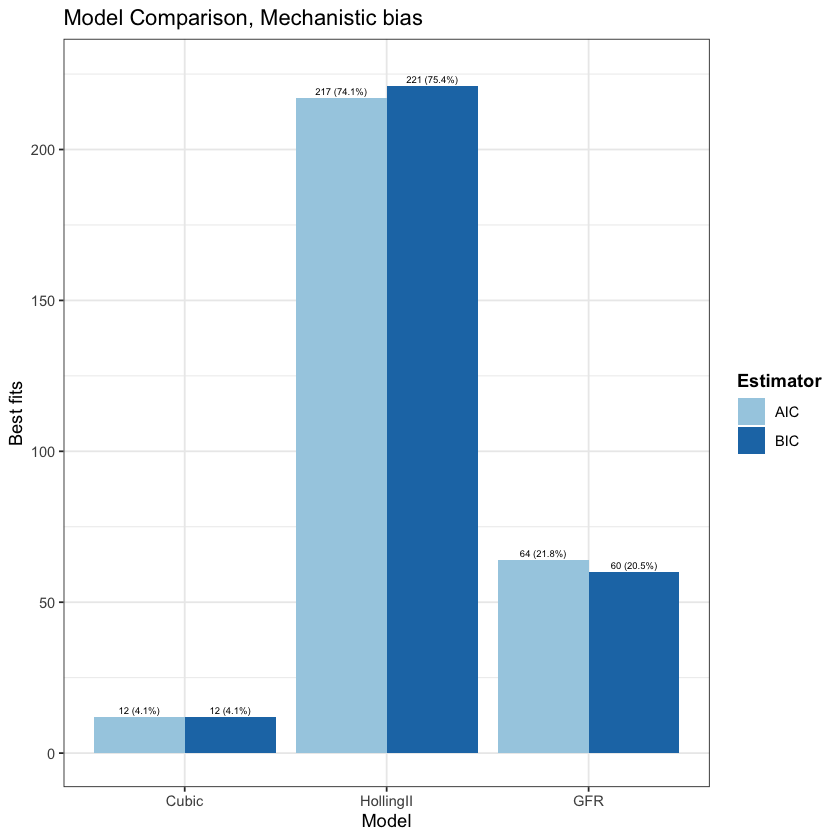

In [156]:
plotBestFits(ALLDATA, 'AICBestFits', 'BICBestFits', 'Model Comparison, no bias, ties ignored.')

plotBestFits(ALLDATA, 'AICBestFits_MechBias', 'BICBestFits_MechBias', 'Model Comparison, Mechanistic bias')

### Add column for winning model overall? Or just choose a measure to go by?

* AIC is generally favored due to its roots in Kullback – Leibler infor- mation theory (Johnson Omland)
* BIC includes a penalty term dependent on sample size, and as such favors simpler models, particularly as sample size increases.
* Model averaging to get best?
* For those cases where a tie exists between Holling 2 and GFR, Holl2 was preffered as a matter of parsimony. The penalty for an additional parameter in model selection is +2 AIC units, and as such if $\Delta{AIC}<2$ then the extra explanatory power provided by the additional phenomnological 'q' parameter introduced in the GFR model is insufficient to justify its inclusion. (Arnold 2010)
* Mechanistic was chosen ove rphenomelogical for similar reasons
* As seen above, this adjustment gave Holling's Type II model an overwhelming edge over the other two

### Holling 1 Transformation (??)

In [141]:
Holling2conv <- ALLDATA[round(ALLDATA$h_Holl2) == 0,]$ID  # All holling 2s with h -> 0 (can be considered holling 1s)
GFRconv <- ALLDATA[round(ALLDATA$h_GFR) == 0,]$ID
#ALLDATA[ALLDATA$ID %in% intersect(Holling2conv, GFRconv),]
#ALLDATA[ALLDATA$ID %in% Holling2conv,]  # table of all IDS with Holling I

## ----------------------------------

# Questions:
1. Which models best fit the data, phenomenological or mechanistic? Why?
2. Which models best fit which consumer foraging movement types (active or passive)? Why might this be?
3. Is there any relationship between habitat and functional response?

### 1. Which models best fit the data, phenomenological or mechanistic? Why?

#### Answer: Mechanistic

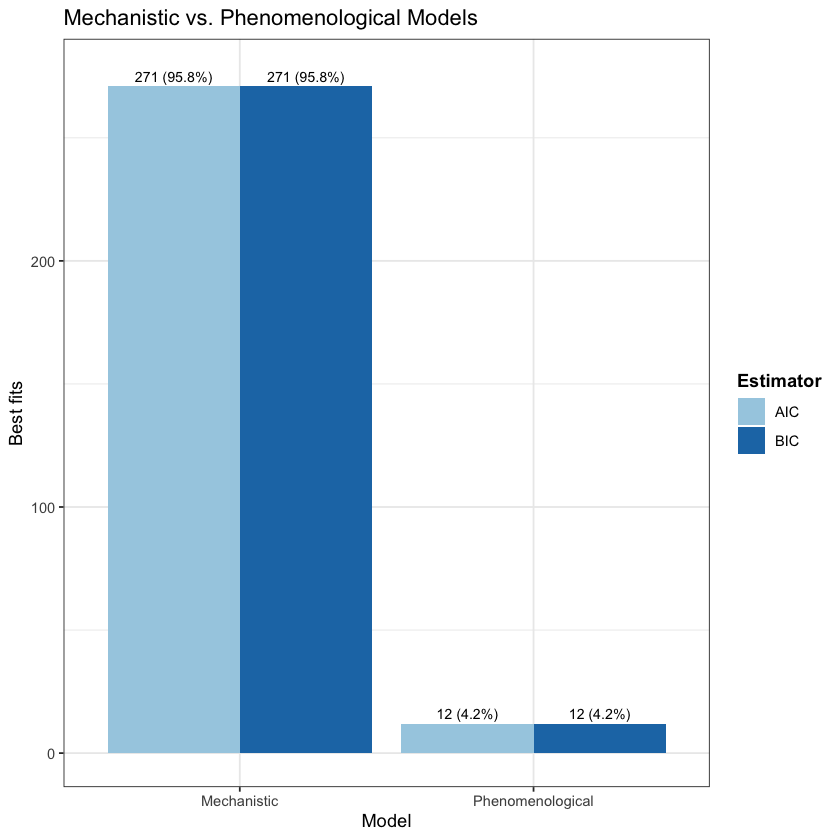

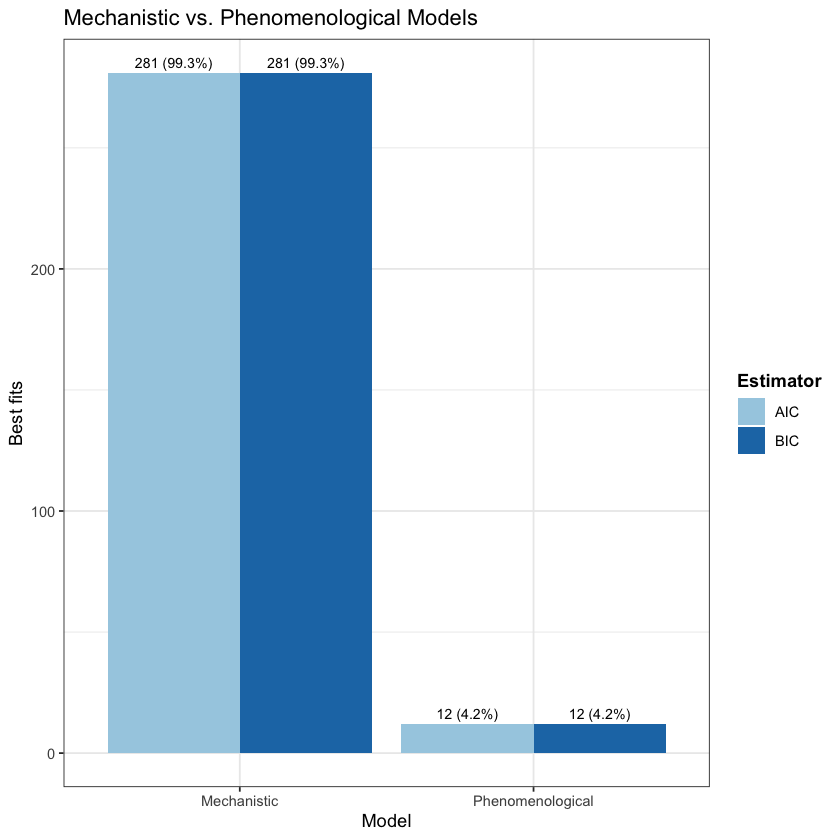

In [161]:
############### Add columns for winning model(s) type #############################
addBestModelType <- function(x){
  if (x %in% c('HollingII', 'GFR', 'HollingII/GFR')){
    return('Mechanistic')
  } else if (x %in% c('Quadratic', 'Cubic', 'Quadratic/Cubic')){
    return('Phenomenological')
  } else {
    return('TIE')
  }
}

# AIC
BestModelTypeAIC <- sapply(ALLDATA$AICBestFits, addBestModelType, USE.NAMES = FALSE) # No bias
BestModelTypeAIC_MechBias <- sapply(ALLDATA$AICBestFits_MechBias, addBestModelType, USE.NAMES = FALSE) # Mech bias
ALLDATA$BestModelTypeAIC <- BestModelTypeAIC
ALLDATA$BestModelTypeAIC_MechBias <- BestModelTypeAIC_MechBias

# BIC
BestModelTypeBIC <- sapply(ALLDATA$BICBestFits, addBestModelType, USE.NAMES = FALSE) # No bias
BestModelTypeBIC_MechBias <- sapply(ALLDATA$BICBestFits_MechBias, addBestModelType, USE.NAMES = FALSE) # Mech bias
ALLDATA$BestModelTypeBIC <- BestModelTypeBIC
ALLDATA$BestModelTypeBIC_MechBias <- BestModelTypeBIC_MechBias

######### No Bias ##############
aicTypeBreakdown <- table(ALLDATA$BestModelTypeAIC)
bicTypeBreakdown <- table(ALLDATA$BestModelTypeBIC)

# Preallocate dataframe containing no. of datapoints best explained by each model
typefitdata <- data.frame(ModelType = rep(c('Phenomenological', 'Mechanistic'), times = 2), 
                      Estimator = rep(c('AIC', 'BIC'), each = 2),
                      Count = rep(NA, times = 4))

for (i in 1:nrow(typefitdata)){
  modtype <- typefitdata[i,'ModelType']
  stat <- typefitdata[i,'Estimator']
  if (stat == 'AIC'){
    typefitdata[i,'Count'] <- ifelse(is.na(aicTypeBreakdown[modtype]), 0, aicTypeBreakdown[[modtype]])
  } else {
    typefitdata[i,'Count'] <- ifelse(is.na(bicTypeBreakdown[modtype]), 0, bicTypeBreakdown[[modtype]])
  }
}

######### Mechanistic Bias ##############
aicTypeBreakdown_bias <- table(ALLDATA$BestModelTypeAIC_MechBias)
bicTypeBreakdown_bias <- table(ALLDATA$BestModelTypeBIC_MechBias)

# Preallocate dataframe containing no. of datapoints best explained by each model
typefitdata_bias <- data.frame(ModelType = rep(c('Phenomenological', 'Mechanistic'), times = 2), 
                          Estimator = rep(c('AIC', 'BIC'), each = 2),
                          Count = rep(NA, times = 4))

for (i in 1:nrow(typefitdata_bias)){
  modtype <- typefitdata_bias[i,'ModelType']
  stat <- typefitdata_bias[i,'Estimator']
  if (stat == 'AIC'){
    typefitdata_bias[i,'Count'] <- ifelse(is.na(aicTypeBreakdown_bias[modtype]), 0, aicTypeBreakdown_bias[[modtype]])
  } else {
    typefitdata_bias[i,'Count'] <- ifelse(is.na(bicTypeBreakdown_bias[modtype]), 0, bicTypeBreakdown_bias[[modtype]])
  }
}

###################################################################################

# Plot
n <- sum(typefitdata['Count'])/2  # Assumes BIC and AIC have same no of total phenom and mech models winning

ggplot(data = typefitdata, aes(x = factor(ModelType), y = Count, fill = Estimator)) + 
    geom_bar(stat="identity", position = 'dodge') +
    ggtitle("Mechanistic vs. Phenomenological Models") +
    labs(x = 'Model', y = 'Best fits') + 
    theme_bw() +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(Count, ' (', round((Count/n)*100, 1), '%)', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 3) +
    expand_limits(y = max(fitdata$Count)*1.02) +
    scale_fill_brewer(palette="Paired")

ggplot(data = typefitdata_bias, aes(x = factor(ModelType), y = Count, fill = Estimator)) + 
    geom_bar(stat="identity", position = 'dodge') +
    ggtitle("Mechanistic vs. Phenomenological Models") +
    labs(x = 'Model', y = 'Best fits') + 
    theme_bw() +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(Count, ' (', round((Count/n)*100, 1), '%)', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 3) +
    expand_limits(y = max(fitdata$Count)*1.02) +
    scale_fill_brewer(palette="Paired")

* It is clear that the mechanistic models considerably outperformed their phenomelogical counterparts. According to both estimators,  between 96.1% and 99.3% of IDs were best fit by a mechanistic model, regardless of whether the bias towards mechanistic models was applied (excluding IDs for which the fits between the two model types could be considered a statistical 'tie' — i.e. $|\Delta{AIC}|<2$ or $|\Delta{BIC}|<2$) 
* Thus.. blabla

In [124]:
ALLDATA

ID,ResDensityUnit,TraitUnit,ConTaxa,ResTaxa,Habitat,Con_ForagingMovement,Res_ForagingMovement,Quadratic_AIC,Cubic_AIC,⋯,GFR_BIC,h_Holl2,a_Holl2,h_GFR,a_GFR,q_GFR,AICBestFits,BICBestFits,BestModelTypeAIC,BestModelTypeBIC
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
39835,Individuals per arena,Individual/(Individual*120 mins),Cyclops bicuspidatus Claus 1857,Panagrolaimus spp.,Freshwater,active,active,-104.716731,-104.716731,⋯,-123.34749,2.929391e+01,9.663936e-05,1.006052e-04,1.280864e-04,-0.108760019,HollingII/GFR,HollingII/GFR,Mechanistic,Mechanistic
39836,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-184.428103,-197.851427,⋯,-223.53567,1.670312e+02,2.818301e-05,1.607115e+02,3.013700e-05,-0.018841384,HollingII/GFR,HollingII/GFR,Mechanistic,Mechanistic
39837,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-172.961157,-174.367043,⋯,-198.99262,1.652989e+02,1.301181e-05,1.114400e+02,1.673661e-05,-0.070704689,HollingII/GFR,HollingII/GFR,Mechanistic,Mechanistic
39838,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-205.404303,-205.546383,⋯,-230.94130,1.680778e+02,6.239453e-06,1.738551e+02,6.142309e-06,0.004324416,HollingII/GFR,HollingII,Mechanistic,Mechanistic
39839,Individuals per arena,Individual/(Individual*90 mins),Rhyacophila dorsalis (Curtis 1834),Chironomus spp.,Freshwater,active,active,-194.766750,-200.139300,⋯,-212.74859,5.768981e+02,5.137557e-06,2.647103e+02,7.299716e-06,-0.113858878,HollingII/GFR,HollingII/GFR,Mechanistic,Mechanistic
39840,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-16.076323,-16.753945,⋯,-110.96360,1.281639e+00,5.701892e-01,1.409983e-08,3.209590e-01,-0.559046197,HollingII/GFR,HollingII,Mechanistic,Mechanistic
39841,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-29.987633,-38.616104,⋯,-145.61726,9.340270e-01,1.849437e+00,1.020914e+00,2.421256e+00,0.279070670,HollingII/GFR,HollingII,Mechanistic,Mechanistic
39842,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-4.055701,-4.169312,⋯,-88.10865,8.998092e-01,1.008196e+00,9.963064e-01,1.125677e+00,0.247484722,HollingII/GFR,HollingII,Mechanistic,Mechanistic
39843,Individuals per arena,individual / (individual * second),Salvelinus alpinus (Linnaeus 1758),Daphnia longispina (O.F. Mller 1776),Freshwater,active,active,-24.817686,-26.538195,⋯,-101.33954,8.625581e-01,1.794689e+00,9.628883e-01,2.395226e+00,0.288655836,HollingII/GFR,HollingII,Mechanistic,Mechanistic


### 2. Which models best fit which consumer foraging movement types (active or passive)? Why might this be?

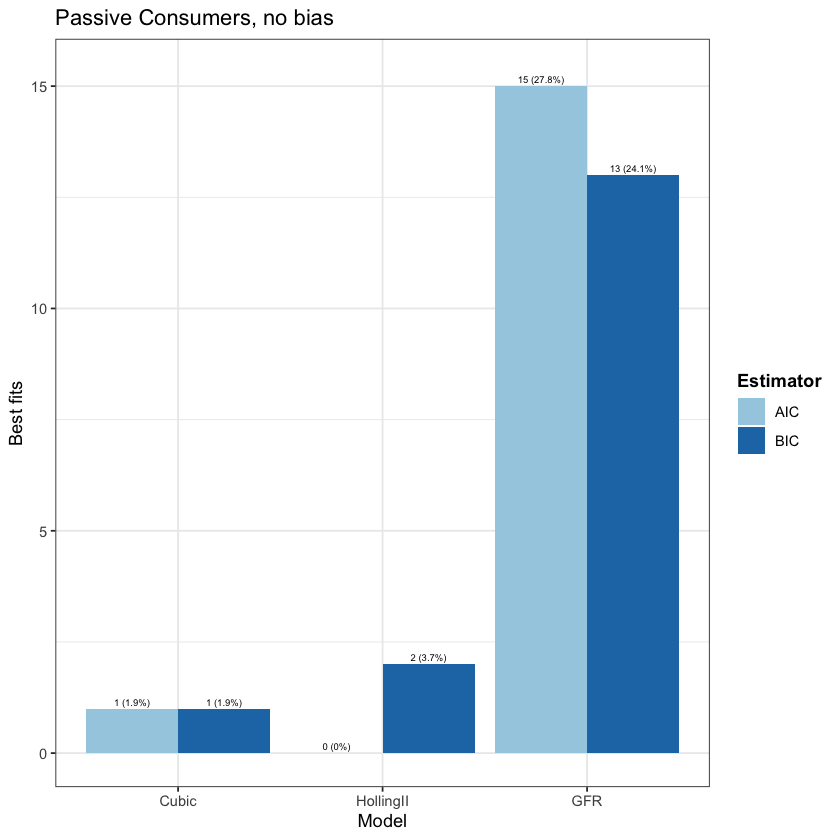

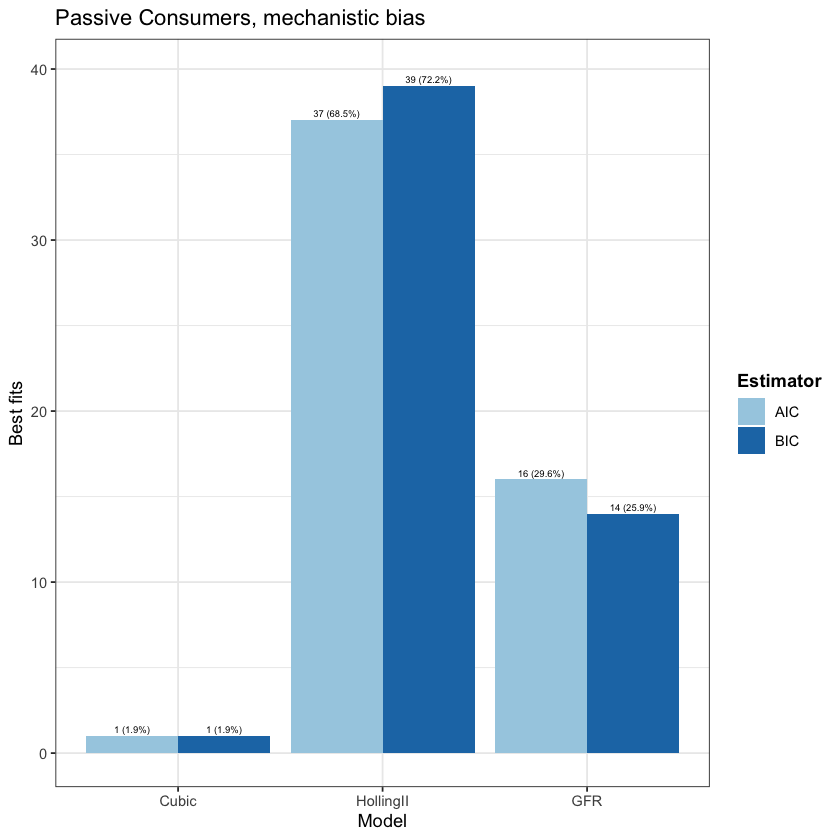

In [163]:
##################### PASSIVE CONSUMERS #############################
pasvID <- unique(subset(frData, Con_ForagingMovement == "sessile")$ID)
pasvCons <- ALLDATA[ALLDATA$ID %in% pasvID,]
plotBestFits(pasvCons, 'AICBestFits', 'BICBestFits', "Passive Consumers, no bias")
plotBestFits(pasvCons, 'AICBestFits_MechBias', 'BICBestFits_MechBias',"Passive Consumers, mechanistic bias")


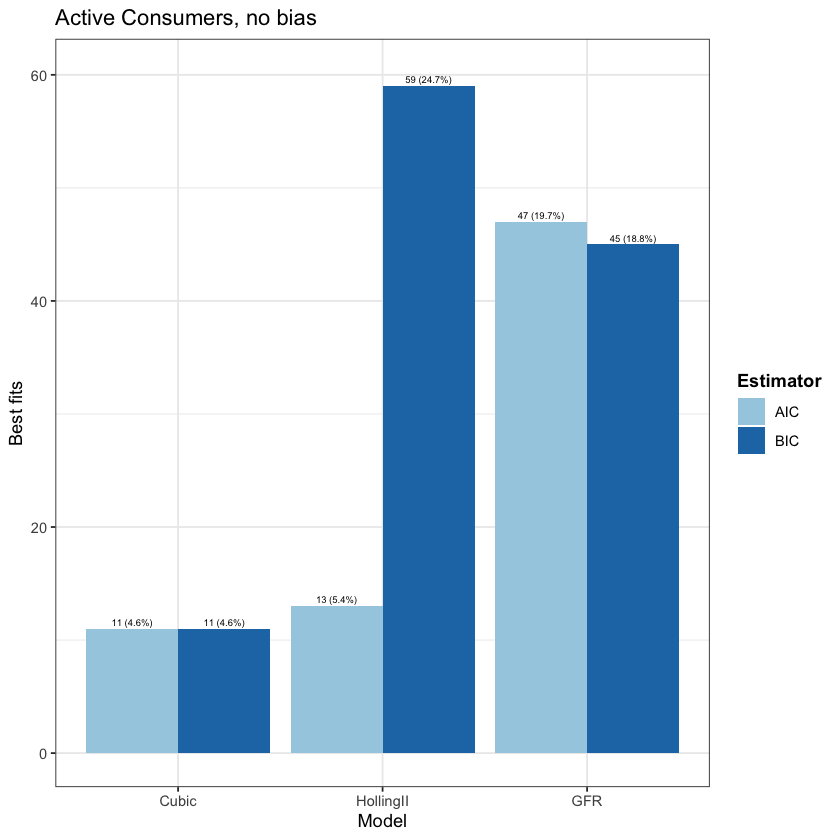

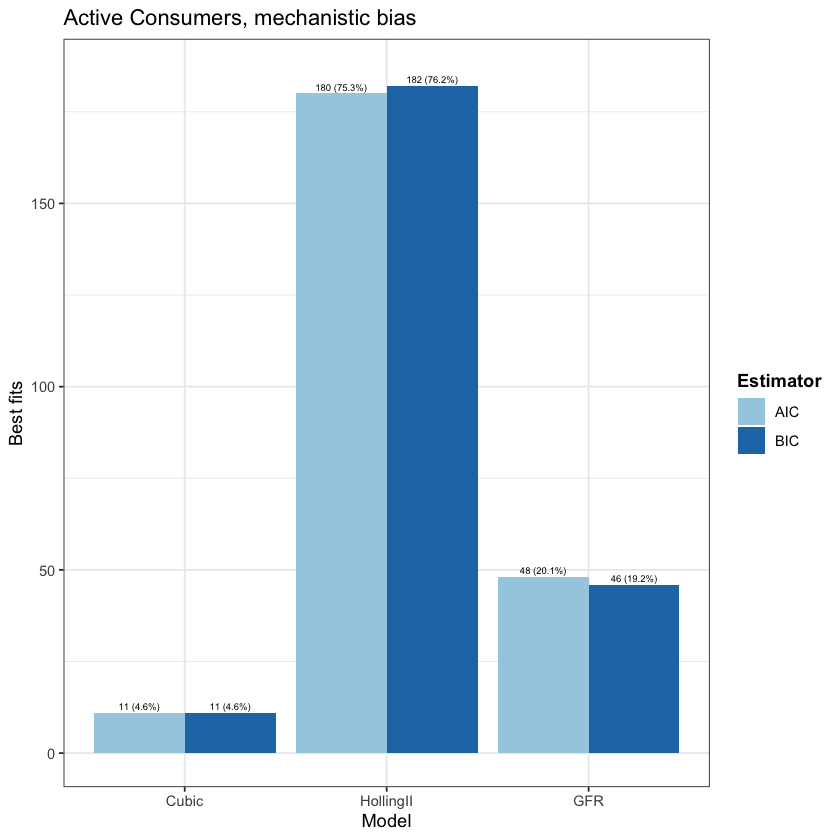

In [164]:
##################### ACTIIVE CONSUMERS #############################
actvID <- unique(subset(frData, Con_ForagingMovement == "active")$ID)
actvCons <- ALLDATA[ALLDATA$ID %in% actvID,]
plotBestFits(actvCons, 'AICBestFits', 'BICBestFits', "Active Consumers, no bias") # no bias
plotBestFits(actvCons, 'AICBestFits_MechBias', 'BICBestFits_MechBias',"Active Consumers, mechanistic bias") # bias

* Both estimators agree on the relative performances of each model category, but disagree on how to divide their respective success among their constituent models. More specifically, it is clear that mechanistic models far outperformed their phenomological counterparts, but determining which model wins depends on which estimator one decides to use.

In [166]:
suppressMessages(library(janitor))
con_movement_tab <- ALLDATA %>%
                    tabyl(Con_ForagingMovement, AICBestFits) %>% # create table
                    adorn_totals("row") %>% # add total counts
                    adorn_percentages("row") %>% # add percentages
                    adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
                    adorn_ns() %>% # add counts
                    rename("Consumer Foraging Movement" = "Con_ForagingMovement") # rename columns

con_movement_tab

res_movement_tab <- ALLDATA %>%
                    tabyl(Res_ForagingMovement, AICBestFits) %>% # create table
                    adorn_totals("row") %>% # add total counts
                    adorn_percentages("row") %>% # add percentages
                    adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
                    adorn_ns() %>% # add counts
                    rename("Resource Foraging Movement" = "Res_ForagingMovement") # rename columns

res_movement_tab

,Consumer Foraging Movement,Cubic,Cubic/GFR,Cubic/HollingII/GFR,GFR,HollingII,HollingII/GFR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,active,5% (11),0% (1),3% (8),20% (47),5% (13),67% (159)
2,sessile,2% (1),2% (1),0% (0),28% (15),0% (0),69% (37)
3,Total,4% (12),1% (2),3% (8),21% (62),4% (13),67% (196)


,Resource Foraging Movement,Cubic,Cubic/GFR,Cubic/HollingII/GFR,GFR,HollingII,HollingII/GFR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,active,4% (9),1% (2),3% (6),18% (39),5% (11),69% (152)
2,passive,7% (1),0% (0),0% (0),29% (4),0% (0),64% (9)
3,sessile,3% (2),0% (0),3% (2),32% (19),3% (2),58% (35)
4,Total,4% (12),1% (2),3% (8),21% (62),4% (13),67% (196)


In [95]:
names(ALLDATA)

[1] "ID"                   "ResDensityUnit"       "TraitUnit"           
 [4] "ConTaxa"              "ResTaxa"              "Habitat"             
 [7] "Con_ForagingMovement" "Res_ForagingMovement" "Quadratic_AIC"       
[10] "Cubic_AIC"            "HollingII_AIC"        "GFR_AIC"             
[13] "Quadratic_BIC"        "Cubic_BIC"            "HollingII_BIC"       
[16] "GFR_BIC"              "h_Holl2"              "a_Holl2"             
[19] "h_GFR"                "a_GFR"                "q_GFR"               
[22] "AICBestFits"          "BICBestFits"          "BestModelTypeAIC"    
[25] "BestModelTypeBIC"

We can see that:
1. for active consumers:
    * GFR best described the relationship between the consumption rate of a passive predator and the abundance of its prey

2. For passive consumers:
    * 